### 순환 신경망의 고급 사용법

- 순환 드롭아웃(recurrent dropout)
- 스태킹 순환 층(stacking recurrent layer)
- 양방향 순환 층(bidirectional recurrent layer)

In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [14]:
float_data.shape

(420551, 14)

In [4]:
len(header)

15

In [8]:
lines[0].split(',')

['01.01.2009 00:10:00',
 '996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

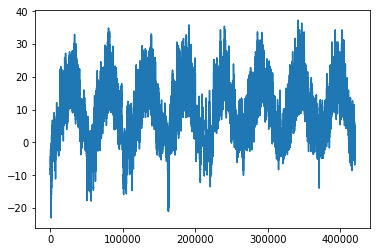

In [10]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] # 온도(섭씨)
plt.plot(range(len(temp)), temp)

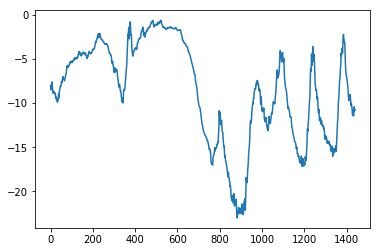

In [15]:
# 처음 10일간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

In [22]:
#  데이터 준비
# lookback 타임슽텝만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링한다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측할 수 있을까?

# 데이터 정규화
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [29]:
# 시계열 데이터와 타깃을 반환하는 제너레이터 함수
# data : 정규화한 부동 소수 데이터로 이루어진 원본 배열
# lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
# delay : 타깃으로 사용할 미래의 타임스텝
# min_index와 max_index : 추출할 타임스텝의 범위를 지정하기 위한 data 배열의 인ㄷ게스, 검증 데이터와 테스트 데이터를 분리하는데 사용
# shuffle : 샘플을 섞을지, 시간 순서대로 추출할 지를 결정
# batch_size : 배치의 샘플 수
# step: 데이터를 샘플링할 타임스텝 간격, 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [30]:
# 훈련, 검증, 테스트 제너레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
test_step = (len(float_data) - 300001 - lookback) // batch_size # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수

In [31]:
# 상식 수준의 기준점
# 상식적인 기준 모델의 MAE(평균 절댓값 오차 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()
# 출력되는 MAE는 0.29 정도인데, 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와닷지 않는다.
# 평균 절댓값 오차 0.29에 표준편차를 곱하면 섭씨 2.57도씨가 된다.

0.2897359729905486


In [32]:
# MAE를 섭씨 단위로 변환
celsius_mae = 0.29 * std[1]

In [33]:
celsius_mae

2.5672247338393395

In [35]:
# 기본적인 머신 러닝 방법
# 데이터를 펼쳐서 2개의 Dense층을 통과시키는 완전 연결 네트워크
# 회귀 문제이므로 마지막 Dense 층에 활성화 함수를 두지 않음.
# 손실함수는 MAE. 앞의 상식 수준의 방법에서 사용한 것과 동일한 데이터와 지표를 사용해서 결과를 바로 비교해 볼 수 있다 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 19ms/step - loss: 1.3745 - val_loss: 0.7898
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.4919 - val_loss: 0.3360
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3163 - val_loss: 0.2962
Epoch 4/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2789 - val_loss: 0.3241
Epoch 5/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2622 - val_loss: 0.3264
Epoch 6/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2509 - val_loss: 0.3159
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2438 - val_loss: 0.3185
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2362 - val_loss: 0.3178
Epoch 9/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2310 - val_loss: 0.3356
Epoch 10/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2256 - 

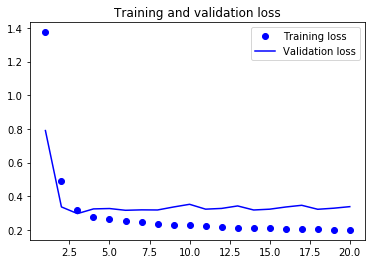

In [36]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
# 첫 번째 순환 신경망
# GRU(Gated Recurrent Unit)를 사용한 모델을 훈련하고 평가
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 71s 142ms/step - loss: 0.3002 - val_loss: 0.2703
Epoch 2/20
500/500 [==============================] - 69s 137ms/step - loss: 0.2840 - val_loss: 0.2685
Epoch 3/20
500/500 [==============================] - 68s 136ms/step - loss: 0.2758 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 77s 154ms/step - loss: 0.2713 - val_loss: 0.2636
Epoch 5/20
500/500 [==============================] - 86s 173ms/step - loss: 0.2679 - val_loss: 0.2690
Epoch 6/20
500/500 [==============================] - 70s 141ms/step - loss: 0.2640 - val_loss: 0.2689
Epoch 7/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2604 - val_loss: 0.2690
Epoch 8/20
500/500 [==============================] - 88s 175ms/step - loss: 0.2583 - val_loss: 0.2670
Epoch 9/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2530 - val_loss: 0.2716
Epoch 10/20
500/500 [==============================] - 96s 193ms/step - l

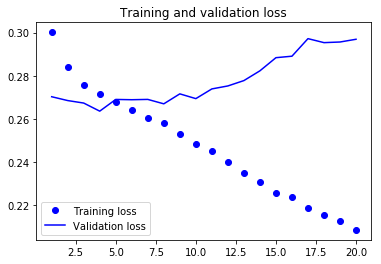

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 78s 155ms/step - loss: 0.3416 - val_loss: 0.2765
Epoch 2/40
500/500 [==============================] - 77s 154ms/step - loss: 0.3163 - val_loss: 0.2762
Epoch 3/40
500/500 [==============================] - 77s 155ms/step - loss: 0.3077 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 80s 159ms/step - loss: 0.3049 - val_loss: 0.2799
Epoch 5/40
499/500 [============================>.] - ETA: 0s - loss: 0.3012

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()